## 手势识别和数据扩增小实验

**任务背景介绍**：数据扩增又称为数据增广，数据增强，它是对训练集进行变换，使训练集更丰富，从而让模型更具泛化能力。

**任务描述**：尝试对样本使用数据增广，并探索它对于手势分类模型预测结果的影响

### 导入需要用的包

In [4]:
import matplotlib.pyplot as plt
import imageio
import pandas as pd
import numpy as np
import torch
from torch import nn
from PIL import Image
import os
import torchvision.transforms as transforms
from models import mobilefacenet
import cv2
%matplotlib inline

### 加载图片

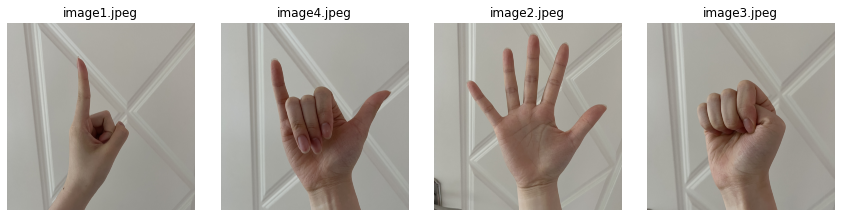

In [5]:
imgpath = "./images" #图片文件夹路径
imagefiles = os.listdir(imgpath)
imgfiles = [file for file in imagefiles if ('.jpeg' or '.jpg' or '.png') in file]

imgs = []
titles = []
for file in imgfiles:
    img = cv2.imread(imgpath + "/" + file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs.append(img)
    titles.append(file) 

plt.figure(figsize=(12, 3))
for i in range(1,5):
    plt.subplot(1,4,i)
    plt.imshow(imgs[i-1])
    plt.title(titles[i-1])
    plt.axis('off') # 关掉坐标轴为 off

plt.tight_layout()
plt.show()

### 根据检测框crop图片

In [6]:
crop_imgs = []
def create_bbox(x, y, bw, bh, w, h):
    midx = int(x + bw / 2)
    midy = int(y + bh / 2)
    
    l = max(bw, bh) * 1.4
    l2 = int(l/2)
    
    x1 = max(0, midx - l2)
    y1 = max(0, midy - l2)
    x2 = min(w, midx + l2)
    y2 = min(h, midy + l2)
    
    return x1, y1, x2, y2
    
    
def crop_hand():
    #读取检测框annotations
    crop_annots = pd.read_csv('./images/annotations.csv') 
    for idx, file in enumerate(imgfiles):
        line = crop_annots.loc[crop_annots['image_name'] == file]
        x1, y1, x2, y2 = create_bbox(int(line['bbox_x']), int(line['bbox_y']), int(line['bbox_width']), int(line['bbox_height']), int(line['image_width']), int(line['image_height']))
        roi = imgs[idx][y1:y2, x1:x2] #top:bottom left:right
        crop_imgs.append(roi)

crop_hand()

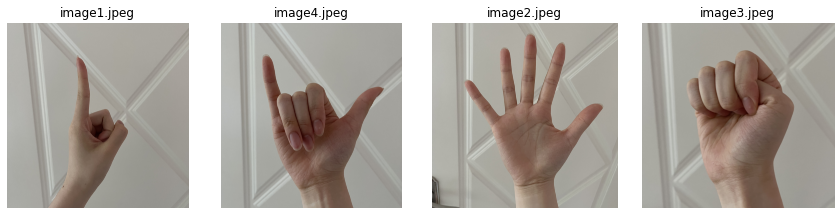

In [7]:
plt.figure(figsize=(12, 3))
for i in range(1,5):
    plt.subplot(1,4,i)
    plt.imshow(crop_imgs[i-1])
    plt.title(titles[i-1])
    plt.axis('off') # 关掉坐标轴为 off

plt.tight_layout()
plt.show()

### 加载模型

In [8]:
pred_cls = {0:'One', 1:'Five', 2:'Fist', 3:'OK', 4:'Heart',5:'Yeah', 8:'Six', 9:'Love', 10:'Eight'
           ,11:'Like'}

In [9]:
model_path = './checkpoint/backbone-epoch35.pth'
head_path = './checkpoint/head-epoch35.pth'

In [10]:
model_name = eval('mobilefacenet.MobileFaceNet')
model = model_name()
head = nn.Linear(512, 24)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
head.load_state_dict(torch.load(head_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [11]:
model.eval()
head.eval()

Linear(in_features=512, out_features=24, bias=True)

In [12]:
test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([224, 224], interpolation=Image.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [1, 1, 1])
    ])

/var/folders/91/4g5nwvg50r542_pn_sphckxr0000gn/T/ipykernel_53379/2712184372.py:3: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  transforms.Resize([224, 224], interpolation=Image.BILINEAR),
/Users/joanna/opt/anaconda3/envs/spark/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


### 预测

In [14]:
outputs = []

for i in range(len(imgs)):
    img = test_transform(crop_imgs[i])
    img = img.unsqueeze(0)
    features = model(img)
    output = head(features)
    outputs.append(output)

In [15]:
preds = []
probs = []
with torch.no_grad():
    for i in range(len(imgs)):
        prob = torch.nn.functional.softmax(outputs[i], dim=1)
        _, pred = outputs[i].topk(1, 1, True, True)
        preds.append(pred.item())
        probs.append(round(prob[0][pred.item()].item()*100,6))

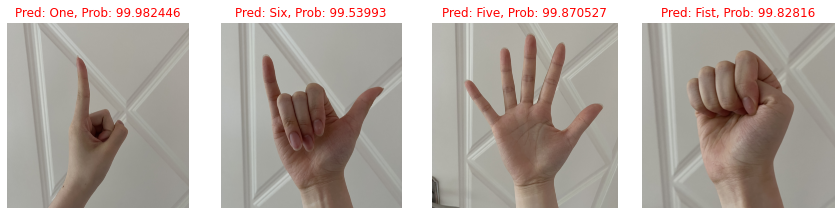

In [16]:
plt.figure(figsize=(12, 3))
for i in range(1,5):
    plt.subplot(1,4,i)
    plt.imshow(crop_imgs[i-1])
    plt.title(f"Pred: {pred_cls[preds[i-1]]}, Prob: {probs[i-1]}",color='red')
    plt.axis('off') # 关掉坐标轴为 off

plt.tight_layout()
plt.show()

## Image Augmentation 数据扩增

**Imgaug是一个封装好的用来进行图像augmentation的python库，GitHub：https://github.com/aleju/imgaug**


### 导入需要用的包

In [17]:
import imgaug as ia
import imgaug.augmenters as iaa

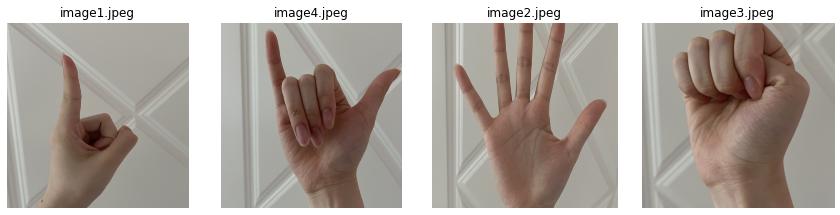

In [18]:
# 随机裁剪
aug = iaa.Crop(percent=(0, 0.2))
imgs_aug = aug(images=crop_imgs) 

plt.figure(figsize=(12, 3))
for i in range(1,5):
    plt.subplot(1,4,i)
    plt.imshow(imgs_aug[i-1])
    plt.title(titles[i-1])
    plt.axis('off') 

plt.tight_layout()
plt.show()

### 预测
**看看数据扩增后的图片预测结果有什么变化吧**

In [19]:
aug_outputs = []

for i in range(len(imgs)):
    img = test_transform(imgs_aug[i])
    img = img.unsqueeze(0)
    features = model(img)
    output = head(features)
    aug_outputs.append(output)

In [20]:
aug_preds = []
aug_probs = []
with torch.no_grad():
    for i in range(len(imgs)):
        prob = torch.nn.functional.softmax(aug_outputs[i], dim=1)
        _, pred = aug_outputs[i].topk(1, 1, True, True)
        aug_preds.append(pred.item())
        aug_probs.append(round(prob[0][pred.item()].item()*100,6))

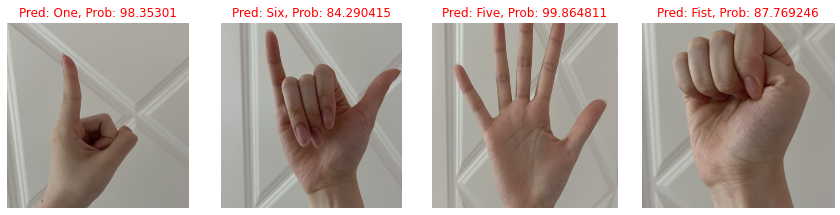

In [21]:
plt.figure(figsize=(12, 3))
for i in range(1,5):
    plt.subplot(1,4,i)
    plt.imshow(imgs_aug[i-1])
    plt.title(f"Pred: {pred_cls[aug_preds[i-1]]}, Prob: {aug_probs[i-1]}",color='red')
    plt.axis('off') # 关掉坐标轴为 off

plt.tight_layout()
plt.show()

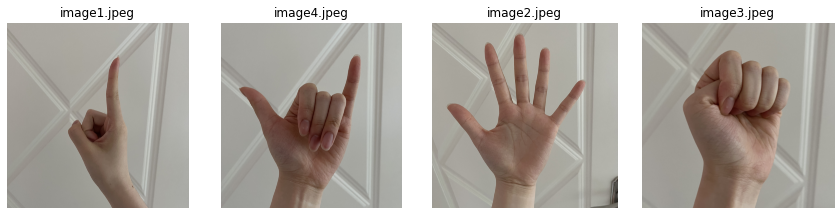

In [22]:
# 左右翻转
aug = iaa.Fliplr()
imgs_aug = aug(images=crop_imgs) 

plt.figure(figsize=(12, 3))
for i in range(1,5):
    plt.subplot(1,4,i)
    plt.imshow(imgs_aug[i-1])
    plt.title(titles[i-1])
    plt.axis('off') # 关掉坐标轴为 off

plt.tight_layout()
plt.show()

### 同时叠加多个增强效果

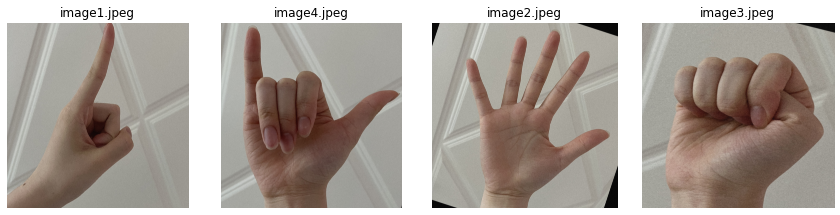

In [30]:
seq = iaa.Sequential([ #将一系列扩增串联在一起
    iaa.Affine(rotate=(-25, 25)),
    iaa.AdditiveGaussianNoise(scale=(10, 40)),
    iaa.Crop(percent=(0, 0.2))
], random_order=True) #随机顺序

imgs_aug = seq(images=crop_imgs)

plt.figure(figsize=(12, 3))
for i in range(1,5):
    plt.subplot(1,4,i)
    plt.imshow(imgs_aug[i-1])
    plt.title(titles[i-1])
    plt.axis('off') # 关掉坐标轴为 off

plt.tight_layout()
plt.show()

### 其他数据扩增的方法：

1. 高斯模糊：iaa.GaussianBlur(sigma=(0.0, 3.0))
2. 改变色温：iaa.ChangeColorTemperature((1100, 10000))
3. 旋转：iaa.Rotate((-45, 45))
4. 增加边框：iaa.Pad(px=(0, 10))
5. 随机增强对比度：iaa.LinearContrast((0.75, 1.5))

**自己尝试组合一下，看看预测结果的变化吧！**

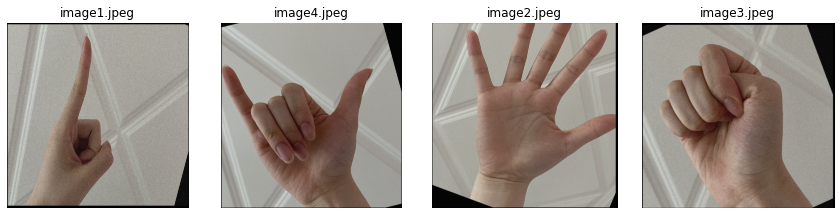

In [34]:
seq = iaa.Sequential([
    iaa.Affine(rotate=(-25, 25)),
    iaa.AdditiveGaussianNoise(scale=(10, 40)),
    iaa.Crop(percent=(0, 0.2)),
    iaa.Pad(px=(0, 40)),
], random_order=True)

imgs_aug = seq(images=crop_imgs)

plt.figure(figsize=(12, 3))
for i in range(1,5):
    plt.subplot(1,4,i)
    plt.imshow(imgs_aug[i-1])
    plt.title(titles[i-1])
    plt.axis('off') # 关掉坐标轴为 off

plt.tight_layout()
plt.show()

### 预测

In [35]:
aug_outputs = []

for i in range(len(imgs)):
    img = test_transform(imgs_aug[i])
    img = img.unsqueeze(0)
    features = model(img)
    output = head(features)
    aug_outputs.append(output)

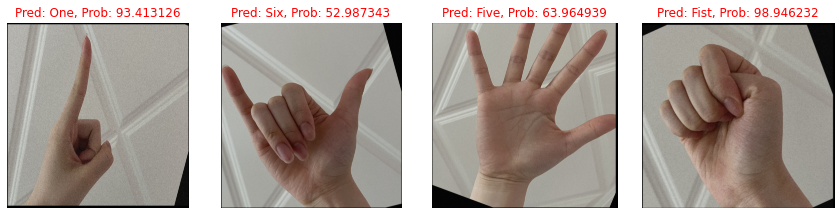

In [36]:
aug_preds = []
aug_probs = []
with torch.no_grad():
    for i in range(len(imgs)):
        prob = torch.nn.functional.softmax(aug_outputs[i], dim=1)
        _, pred = aug_outputs[i].topk(1, 1, True, True)
        aug_preds.append(pred.item())
        aug_probs.append(round(prob[0][pred.item()].item()*100,6))

plt.figure(figsize=(12, 3))
for i in range(1,5):
    plt.subplot(1,4,i)
    plt.imshow(imgs_aug[i-1])
    plt.title(f"Pred: {pred_cls[aug_preds[i-1]]}, Prob: {aug_probs[i-1]}",color='red')
    plt.axis('off') # 关掉坐标轴为 off

plt.tight_layout()
plt.show()